In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False
%cd ..

/jupyter-lab/repo/bigstar


# Import Modules

In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["TRANSFORMERS_VERBOSITY"] = "error"

import pickle
from collections import Counter
from functools import partial
from pathlib import Path
from typing import Dict, Iterable, Tuple

import joblib
import matplotlib.pyplot as plt
import mecab_ko as mecab
import nlpaug.augmenter.word as naw
import numpy as np
import pandas as pd
import scipy.special as sp
import seaborn as sns
import torch
from nlpaug.util import Action
from scipy.sparse import csr_matrix
from scipy.special import softmax
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from src.base_trainer import get_ckpt_path, get_model_hparams, load_model_state
from src.baseline.models import BaselineModel, BaselineModelWithMLAttention
from src.baseline.trainer import BaselineTrainerModel
from src.datasets import LotteQADataset, collate_fn
from src.eda import EDA
from src.utils import (
    delete_list_elements,
    filter_arguments,
    get_label_encoder,
    get_n_samples,
)
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from transformers import (
    AutoConfig,
    AutoModel,
    AutoModelForCausalLM,
    AutoModelForMaskedLM,
    AutoTokenizer,
    MarianMTModel,
)
from transformers.models.marian.convert_marian_to_pytorch import (
    load_config_from_state_dict,
)
from transformers.tokenization_utils_base import PreTrainedTokenizerBase

plt.rcParams["font.family"] = "NanumGothic"

# EDA

## # of Samples

In [30]:
train_df1 = pd.read_csv("data/train01.csv")
train_df1 = train_df1[train_df1["QA여부"] == "q"]

train_df2 = pd.read_csv("data/train02.csv")
train_df2 = train_df2[train_df2["QA여부"] == "q"]

train_df = pd.concat([train_df1, train_df2])

valid_df = pd.read_csv("data/validation.csv")
valid_df = valid_df[valid_df["QA여부"] == "q"]

test_df = pd.read_csv("data/test.csv")
test_df = test_df[test_df["QA여부"] == "q"]

print(f"# of rows (train01): {len(train_df1):,}")
print(f"# of rows (train02): {len(train_df2):,}")
print(f"# of rows (validation): {len(valid_df):,}")
print(f"# of rows (test): {len(test_df):,}")

train_df1.head()

# of rows (train01): 441,874
# of rows (train02): 273,175
# of rows (validation): 114,288
# of rows (test): 89,878


,IDX,발화자,발화문,카테고리,QA번호,QA여부,감성,인텐트,가격,수량,크기,장소,조직,사람,시간,날짜,상품명,상담번호,상담내순번
0,433813,c,높이 길이를 좀 더 길게 해주실 수 있나요?,가구인테리어,1,q,m,제품_정보,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
2,441787,c,그레이 커튼을 배송받았는데요레이스 커튼이 흰색이 아니고 회색이네요 잘못 온 건가요?,가구인테리어,2,q,m,배송_오류,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,그레이 커튼|레이스 커튼,2,1
4,325930,c,거실 총길이가 가로 480세로 230인데 어떤 걸로 신청해야 하나요?,가구인테리어,4,q,m,제품_정보,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1
6,70824,c,레이스 커튼만 개별 구매 안 될까요?,가구인테리어,5,q,m,구매_제품,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,레이스 커튼,5,1
8,253329,c,화이트 구입 시 봉색이 화이트로 오나요?,가구인테리어,6,q,m,제품_구성,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,1


## # of Samples per Label

In [83]:
value_counts = pd.DataFrame(train_df['인텐트'].value_counts())
value_counts

,인텐트
배송_날짜,153516
제품_정보,124759
제품_구성,46528
제품_방법,42915
제품_추천,39719
...,...
주문_변경,132
포장_비용,125
주문_오류,106
주문_추가,103


## Label Distribution

<AxesSubplot:>

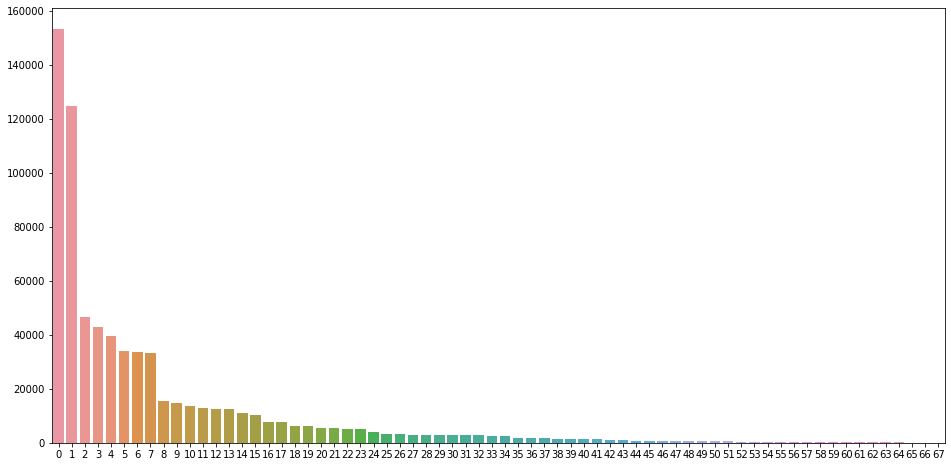

In [82]:
plt.figure(figsize=(16, 8))
sns.barplot(x=np.arange(len(value_counts)), y=value_counts["인텐트"].to_numpy())

## Stat of Input Token

In [124]:
tokenzier = AutoTokenizer.from_pretrained("monologg/koelectra-small-v3-discriminator")
input_lengths = []
for text in tqdm(train_df["발화문"]):
    input_lengths.append(len(tokenzier(text)["input_ids"]))

input_lengths = np.array(input_lengths)
print(f"avg. length of input token: {np.mean(input_lengths):.2f}")
print(f"std. length of input token: {np.std(input_lengths):.2f}")
print(f"median length of input token: {np.median(input_lengths)}")
print(f"min length of input token: {np.min(input_lengths):.2f}")
print(f"max length of input token: {np.max(input_lengths):.2f}")

avg. length of input token: 18.30
std. length of input token: 9.30
median length of input token: 16.0
min length of input token: 4.00
max length of input token: 233.00


# Dataset

In [161]:
dataset = LotteQADataset()
le = LabelEncoder().fit(dataset.y)
tokenizer = AutoTokenizer.from_pretrained("monologg/koelectra-small-v3-discriminator")

In [162]:
dataloader = DataLoader(
    dataset,
    batch_size=16,
    collate_fn=partial(collate_fn, tokenizer=tokenizer, le=le, max_length=30),
)

In [163]:
batch = next(iter(dataloader))

# Model

In [198]:
model = BaselineModel(
    num_labels=len(le.classes_),
    pretrained_model_name="monologg/koelectra-base-v3-discriminator",
    use_layernorm=True,
)

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Test

In [4]:
def predict(run_id, **dataset_kwargs):
    ckpt_path = get_ckpt_path(log_dir="./logs", run_id=run_id, load_best=True)
    model_hparams = get_model_hparams(
        "./logs", run_id, BaselineTrainerModel.MODEL_HPARAMS
    )
    le = get_label_encoder("./cache/label_encoder.joblib")

    model_cls = (
        BaselineModel
        if model_hparams["model_name"] == "Baseline"
        else BaselineModelWithMLAttention
    )

    model = model_cls(
        num_labels=len(le.classes_), **filter_arguments(model_hparams, model_cls)
    )

    load_model_state(model, ckpt_path, substitution=(r"^model\.", ""))

    test_dataset = LotteQADataset(**dataset_kwargs)
    tokenizer = AutoTokenizer.from_pretrained(model_hparams["pretrained_model_name"])
    test_dataloader = DataLoader(
        test_dataset,
        batch_size=16,
        pin_memory=True,
        num_workers=4,
        collate_fn=partial(
            collate_fn,
            tokenizer=tokenizer,
            le=le,
            max_length=model_hparams["max_length"],
        ),
    )

    device = torch.device("cuda")

    model.to(device)
    model.eval()
    probs = []

    for batch_x, batch_y in tqdm(test_dataloader):
        batch_x = {k: v.to(device) for k, v in batch_x.items()}
        with torch.no_grad(), torch.cuda.amp.autocast():
            outputs = model(batch_x)
        probs.append(outputs.cpu())

    probs = np.concatenate(probs)
    predictions = probs.argmax(axis=-1)

    gt = le.transform(test_dataset.y)
    f1_micro = f1_score(gt, predictions, average="micro")
    prec_macro, recall_macro, f1_macro, support = precision_recall_fscore_support(
        gt,
        predictions,
        average="macro",
        zero_division=0,
    )
    prec_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        gt,
        predictions,
        average="weighted",
        zero_division=0,
    )
    prec, recall, f1, _ = precision_recall_fscore_support(
        gt, predictions, average=None, zero_division=0
    )

    print(f"f1        (micro): {f1_micro:.4f}")
    print(f"prec      (macro): {prec_macro:.4f}")
    print(f"recall    (macro): {recall_macro:.4f}")
    print(f"f1        (macro): {f1_macro:.4f}")
    print(f"prec   (weighted): {prec_weighted:.4f}")
    print(f"recall (weighted): {recall_weighted:.4f}")
    print(f"f1     (weighted): {f1_weighted:.4f}")

    matrix = confusion_matrix(gt, predictions)

    data = {
        "intent": le.classes_,
        "support": matrix.sum(axis=-1),
        "# to tp": np.diag(matrix),
        "# of predicted": matrix.sum(axis=0),
    }

    df = pd.DataFrame(data)

    return {
        "df": df,
        "matrix": matrix,
        "f1_micro": f1_micro,
        "prec_macro": prec_macro,
        "recall_macro": recall_macro,
        "prec_weighted": prec_weighted,
        "recall_weighted": recall_weighted,
        "f1_weighted": f1_weighted,
        "prec": prec,
        "recall": recall,
        "f1": f1,
        "gt": gt,
        "predictions": predictions,
        "probs": probs,
    }

In [745]:
predicted = predict(
    run_id="270738eba9094d28926c8c821adb1051", aug_filename="back.v1.csv"
)

predicted["df"].to_excel("outputs/predictions.xlsx", index=False)

## Analysis Predictions

In [180]:
label_idx = le.transform(["제품_일반"])[0]
predicted_label_idx = np.where(matrix[:, label_idx] != 0)[0]
predicted_label_idx = predicted_label_idx[np.where(predicted_label_idx != label_idx)[0]]
predicted = matrix[:, label_idx][predicted_label_idx]

df = pd.DataFrame(
    {"intent": le.classes_[predicted_label_idx], "# of predicted": predicted}
)
df.sort_values(by="# of predicted", ascending=False)

,intent,# of predicted
20,제품_정보,95
19,제품_재고,54
14,제품_방법,41
13,제품_구성,32
1,결제_일반,24
11,웹사이트_사용,14
9,배송_일반,9
22,제품_커스텀,7
18,제품_입고,7
21,제품_추천,5


# Easy Data Augmentation

In [209]:
train_dataset = LotteQADataset()

In [249]:
eda = EDA(num_aug=3, p_sr=0.5, p_ri=0.5, p_rd=0, p_rs=0)

In [350]:
ridx = np.random.randint(len(train_dataset))
original = train_dataset[ridx][0]
augmented = eda(original)

print(f"Original text ({ridx}):")
print(original)
print()
print("Augmented text:")
print("\n".join(augmented))

Original text (580718):
저번에도 신청해서 이번에도 신청했는데 아직도 배송 준비 중이네 여 언제쯤 받아볼 수 있나여? 빨리 보내주세여

Augmented text:
저번에도 신청해서 이번에도 신청했는데 아직도 배송 준비 중이네 여 언제쯤 받아볼 수 있나여? 빨리 보내주세여


In [194]:
eda = EDA(num_aug=3, p_sr=0, p_ri=0, p_rd=0.5, p_rs=0.5)
train_dataset = LotteQADataset()
augmented = []
for text, label in tqdm(train_dataset):
    aug = eda(text)
    augmented.extend([(t, label) for t in aug])

  0%|          | 0/715049 [00:00<?, ?it/s]

In [195]:
text, labels = zip(*augmented)
df = pd.DataFrame({"발화문": text, "인텐트": labels})
df.to_csv('data/augmented.eda.v2.csv', index=False)

In [394]:
model.eval()
predictions = []

for batch_x, batch_y in tqdm(test_dataloader):
    batch_x = {k: v.to(device) for k, v in batch_x.items()}
    with torch.no_grad():
        outputs = model(batch_x)
    predictions.append(outputs.argmax(dim=-1).cpu())

predictions = np.concatenate(predictions)

le = get_label_encoder('./cache/label_encoder')
gt = le.transform(test_dataset.y)
f1_micro = f1_score(gt, predictions, average='micro')
f1_macro = f1_score(gt, predictions, average='macro')
f1 = f1_score(gt, predictions, average=None)

print(f"f1 (micro): {f1_micro:.4f}")
print(f"f1 (macro): {f1_macro:.4f}")

  0%|          | 0/28087 [00:01<?, ?it/s]

f1 (micro): 0.7305
f1 (macro): 0.5125


In [396]:
counter = Counter(gt)

label, cnt = zip(*counter.items())
label = np.array(label)
cnt = np.array(cnt)
idx = np.argsort(label)

data = {"intent": le.classes_, "f1": f1, "support": cnt[idx]}
df = pd.DataFrame(data)
df.to_excel("predictions.xlsx", index=False)

# Backtranslation

In [4]:
device = torch.device("cuda")

def collate_fn_seq2seq(
    batch: Iterable[Tuple[str, str]],
    tokenizer: PreTrainedTokenizerBase,
) -> Tuple[Dict[str, torch.Tensor]]:
    x = [b[0] for b in batch]
    inputs = tokenizer(x, padding=True, return_tensors="pt")
    return inputs

In [3]:
src_model_name = "Helsinki-NLP/opus-mt-ko-en"
src_tokenizer = AutoTokenizer.from_pretrained(src_model_name)
src_model = MarianMTModel.from_pretrained(src_model_name)
_ = src_model.to(device)

In [ ]:
tgt_model_name = "Helsinki-NLP/opus-mt-tc-big-en-ko"
tgt_tokenizer = AutoTokenizer.from_pretrained("../Opus-MT/models/en-ko-2")
tgt_model = MarianMTModel.from_pretrained(tgt_model_name)
_ = tgt_model.to(device)

In [313]:
train_dataset = LotteQADataset()
train_dataloader = DataLoader(
    train_dataset,
    batch_size=32,
    collate_fn=partial(collate_fn_seq2seq, tokenizer=src_tokenizer),
    pin_memory=True,
    num_workers=6,
)

In [ ]:
src_translated = []

src_model.eval()

for batch_x in tqdm(train_dataloader):
    batch_x = {k: v.to(device) for k, v in batch_x.items()}
    with torch.no_grad():
        encoded = src_model.generate(**batch_x)
    with src_tokenizer.as_target_tokenizer():
        src_translated.append(
            src_tokenizer.batch_decode(encoded.cpu(), skip_special_tokens=True)
        )

In [101]:
texts = train_dataset.x[:20].tolist()
texts

['높이 길이를 좀 더 길게 해주실 수 있나요?',
 '그레이 커튼을 배송받았는데요레이스 커튼이 흰색이 아니고 회색이네요 잘못 온 건가요?',
 '거실 총길이가 가로 480세로 230인데 어떤 걸로 신청해야 하나요?',
 '레이스 커튼만 개별 구매 안 될까요?',
 '화이트 구입 시 봉색이 화이트로 오나요?',
 '화이트 구매 안 되나요?',
 '주문 가능할까요?',
 '똑같은 회사에 똑같은 상품인데 2만원 더 비싼데 혹시 상품 이 틀리나요?',
 '사이즈를 몇으로 사야 하나요?',
 '검수 잘해서 배송 부탁드립니다 그리고 배송 날짜가 좀 늦게 뜨는 데 이번 주에 받을 수 있을까요?',
 '대형 사려고 하는데 커튼봉을 시중에 파는 3.5미리로 바꾸어도 커튼 구멍에 맞을까요?',
 '화이트는 언제 입고되나요?',
 '냄새가 많이 나는데 세탁을 하고 사용해야 하나요?',
 '핀 형도 가능한가요?',
 '겨울 방풍 효과도 있나요?',
 '길이 250으로는 안 되나요?',
 '로제2와 로즈마리의 차이점은 뭔가요?',
 '가로490문의요 중형 2개를 사면 커텐봉을 하나로 연결할 수 있나요?',
 '베이지 주문했는데 타이백은 어떤 색 그리고 어떤 게오나요?',
 '가로길이가 340인데 사이즈뭘로 해야 되나요?']

In [103]:
encoded = src_tokenizer(texts, padding=True, return_tensors='pt')
translated = src_model.generate(**encoded)
src_text = src_tokenizer.batch_decode(translated, skip_special_tokens=True)
src_text

['Can you give me a little longer?',
 "The lace curtains are not white, they're gray.",
 'The total length of the living room is 480 years and 230, what should I apply for?',
 "Can't we just buy a lace curtain?",
 'When you buy white, does the bag come to white?',
 "Can't we buy a white one?",
 'Can you order it?',
 "It's the same company and it's worth 20 bucks more, but is it wrong?",
 'What size do I have to buy?',
 "I'd like you to take care of it, and do you mind if I take it this week when the delivery date's up a little late?",
 "I'm trying to buy a big one, but will I fit the curtain hole in a three-and-a-half-a-half-year-old market with a curtain bar?",
 'When are you wearing white?',
 'You smell a lot, so should I wash it and use it?',
 'Is Finn available, too?',
 'Is there a winter wind effect?',
 'Is it 250 feet long?',
 "What's the difference between Roger II and Rosemary?",
 '490 across. If you buy two mediums, can you connect them together?',
 "I ordered a bag of beige. 

In [297]:
encoded = target_tokenizer(src_text, padding=True, return_tensors="pt")
translated = target_model.generate(**encoded)
with target_tokenizer.as_target_tokenizer():
    tgt_text = target_tokenizer.batch_decode(translated, skip_special_tokens=True)
tgt_text

['조금만 더 기다려 주시겠어요?',
 '레이스 커튼은 흰색이 아니라 회색입니다.',
 '거실의 총 길이는 480 년과 230 년이며, 무엇을 신청해야합니까?',
 '그냥 커튼 하나 사면 안 돼?',
 '흰색을 구입하면 가방이 흰색으로 나오나요?',
 '흰색 하나 사면 안 돼?',
 '당신은 그것을 주문할 수 있습니까?',
 '같은 회사이고 20 달러 더 가치가 있지만 잘못 되었습니까?',
 '어떤 사이즈를 구매해야 하나요?',
 '난 당신이 그것을 처리 하 고 싶습니다., 배달 날짜가 조금 늦게 이번 주에 그것을 받아도 될까요?',
 '나는 큰 것을 사려고 노력하고있다. 그러나 나는 커튼 막대가있는 3 년 반의 시장에 커튼 구멍을 넣을 것인가?',
 '흰색은 언제 입고되나요?',
 '냄새를 많이 맡으셨는데, 씻어서 사용해도 되나요?',
 '핀도 사용할 수 있습니까?',
 '겨울 바람의 영향이 있습니까?',
 '길이가 250 피트입니까?',
 'Roger II와 Rosemary의 차이점은 무엇입니까?',
 '490 가로로. 두 개의 매체를 구입하면 함께 연결할 수 있습니까?',
 '베이지색 가방을 주문했는데 무슨 색이고 무슨 일이에요?',
 '폭이 340개인데 크기가 어떻게 되나요?']

---

In [31]:
src_translated = joblib.load("./outputs/backtranslation/src_translated.joblib")
tgt_translated = joblib.load("./outputs/backtranslation/tgt_translated.joblib")

In [23]:
train_dataset = LotteQADataset()

In [60]:
df = pd.DataFrame(
    data={
        "ko": train_dataset.x,
        "en": src_translated,
        "ko (back)": tgt_translated,
        "intent": train_dataset.y,
    }
)

df

,ko,en,ko (back),intent
0,높이 길이를 좀 더 길게 해주실 수 있나요?,Can you give me a little longer?,조금만 더 기다려 주시겠어요?,제품_정보
1,그레이 커튼을 배송받았는데요레이스 커튼이 흰색이 아니고 회색이네요 잘못 온 건가요?,"The lace curtains are not white, they're gray.",레이스 커튼은 흰색이 아니라 회색입니다.,배송_오류
2,거실 총길이가 가로 480세로 230인데 어떤 걸로 신청해야 하나요?,The total length of the living room is 480 yea...,"거실의 총 길이는 480 년과 230 년이며, 무엇을 신청해야합니까?",제품_정보
3,레이스 커튼만 개별 구매 안 될까요?,Can't we just buy a lace curtain?,그냥 커튼 하나 사면 안 돼?,구매_제품
4,화이트 구입 시 봉색이 화이트로 오나요?,"When you buy white, does the bag come to white?",흰색을 구입하면 가방이 흰색으로 나오나요?,제품_구성
...,...,...,...,...
715044,일반 간이영수증에 찍으려고 하는데 사이즈 뭐로 해야 하나요?,"I'm trying to get a normal liver receipt, but ...",나는 정상적인 간 영수증을 얻으려고 노력하고 있지만 그 크기는 얼마입니까?,제품_추천
715045,oo o+전서체로 이쁘게 해서 보내주세요 그리고 언제쯤 받아볼 수 있나요?,"Send it to me with your oo-o+ telegraph, and w...",Oo-o+ 전신으로 나에게 보내면 언제 얻을 수 있습니까?,배송_날짜
715046,입력 내용 다시 입력해야 되나요?,Do I have to re-enter the input?,입력을 다시 입력해야 하나요?,제품_일반
715047,지금 주문하면 언제 보내주세요?,"If you order now, when will you let me go?",지금 주문하면 언제 날 보내줄 거야?,배송_날짜


In [65]:
df[df['en'].isnull()]

,ko,en,ko (back),intent


In [36]:
x = np.concatenate([train_dataset.x, tgt_translated])

In [43]:
y = np.concatenate([train_dataset.y, train_dataset.y])

In [46]:
idx = np.arange(len(x))
np.random.shuffle(idx)

In [47]:
idx

array([ 857385, 1027034,  692522, ...,  585390,  448823,   80854])

In [48]:
x = x[idx]
y = y[idx]

In [85]:
df = pd.DataFrame(data={"발화문": x, "인텐트": y})

In [94]:
df.to_csv("data/augmented.backtranslation.v1.csv", index=False)

# M2m

In [23]:
train_dataset = LotteQADataset()
le = get_label_encoder("cache/label_encoder.joblib")
y = le.transform(train_dataset.y)

In [24]:
counter = Counter(y)
idx, n_samples = zip(*counter.items())
idx = np.array(idx)
n_samples = np.array(n_samples)
n_samples = n_samples[np.argsort(idx)]
n_samples = torch.from_numpy(n_samples)

In [57]:
n_samples

tensor([   500,   1858,   1371,    827,   4003,    313,    155,    454,    202,
           255,   6047,    177,    898,   1804,   1223,   5446,   2915,   4971,
         11123,    141,    556,   3415,   1276,    795,    181,     64,    161,
        153516,   5287,  12500,  13651,  12422,   2845,   2485,    570,   1419,
           633,   2727,    379,   6373,  46528,   2799,  42915,  15572,   7786,
          2531,  10440,   2880,  33130,  34191,  12886, 124759,  39719,   1224,
         14910,  33519,    132,    106,    429,    103,   1664,    125,    849,
          5508,    496,   2860,   7676,   3374])

In [56]:
torch.bernoulli(n_samples[n_samples.argsort(descending=True)] / n_samples.max())

tensor([0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [113]:
y_sample = torch.from_numpy(y[:32])

# Label Distribution

In [16]:
def plot_label_distribution(df, key="인텐트", columns=None):
    value_counts = df[key].value_counts()
    if columns is not None:
        value_counts = value_counts.loc[columns]
    plt.figure(figsize=(16, 8))
    sns.barplot(x=value_counts.index, y=value_counts.to_numpy())

## Original Dataset

<AxesSubplot:>

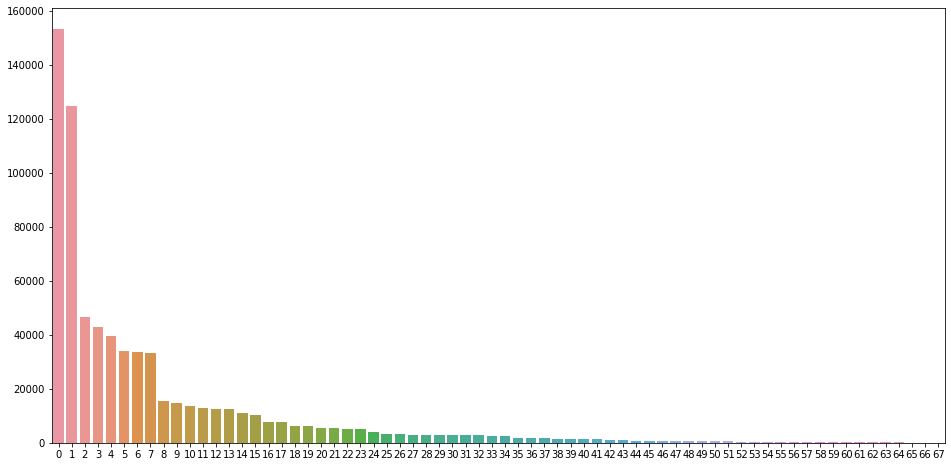

In [419]:
orig_df = pd.concat(
    [
        pd.read_csv("data/train01.csv", low_memory=False),
        pd.read_csv("data/train02.csv", low_memory=False),
    ]
)
orig_df = orig_df[orig_df["QA여부"] == "q"]
orig_df = orig_df[["발화문", "인텐트"]]

orig_value_counts = pd.DataFrame(orig_df["인텐트"].value_counts())

plt.figure(figsize=(16, 8))
sns.barplot(x=np.arange(len(orig_value_counts)), y=orig_value_counts["인텐트"].to_numpy())

## EDA v1

<AxesSubplot:>

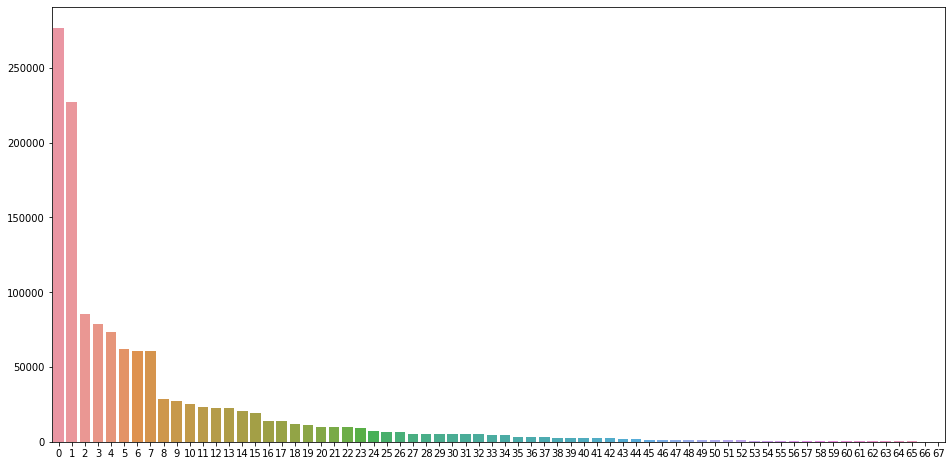

In [307]:
df = pd.read_csv("data/augmented.eda.v1.csv")
value_counts = pd.DataFrame(df["인텐트"].value_counts())
plt.figure(figsize=(16, 8))
sns.barplot(x=np.arange(len(value_counts)), y=value_counts["인텐트"].to_numpy())

## Backtranslation v1

<AxesSubplot:>

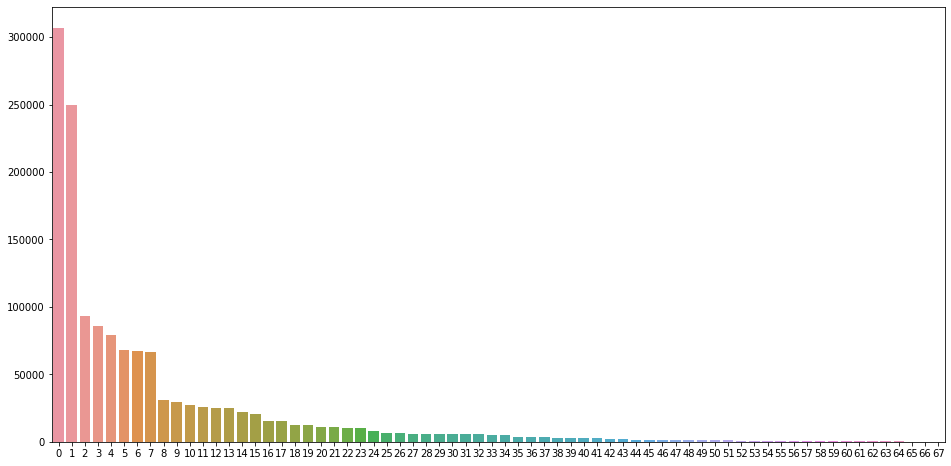

In [305]:
df = pd.read_csv("data/augmented.backtranslation.v1.csv")
value_counts = pd.DataFrame(df["인텐트"].value_counts())
plt.figure(figsize=(16, 8))
sns.barplot(x=np.arange(len(value_counts)), y=value_counts["인텐트"].to_numpy())

## Backtranslation v2

<AxesSubplot:>

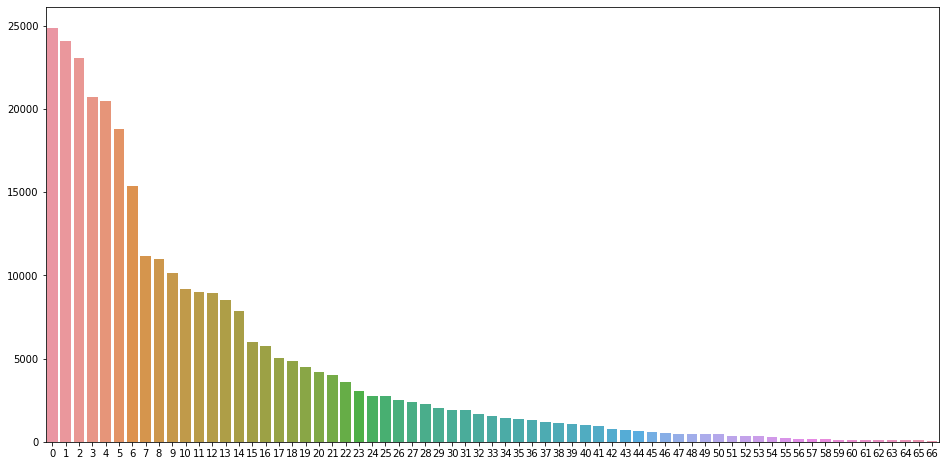

In [440]:
back_translated = joblib.load("outputs/backtranslation/back_translated.joblib")
texts, intents = zip(*back_translated)
df = pd.DataFrame({"발화문": texts, "인텐트": intents})
value_counts = pd.DataFrame(df["인텐트"].value_counts())
plt.figure(figsize=(16, 8))
sns.barplot(x=np.arange(len(value_counts)), y=value_counts["인텐트"].to_numpy())

## Dataset (Only main category)

<AxesSubplot:>

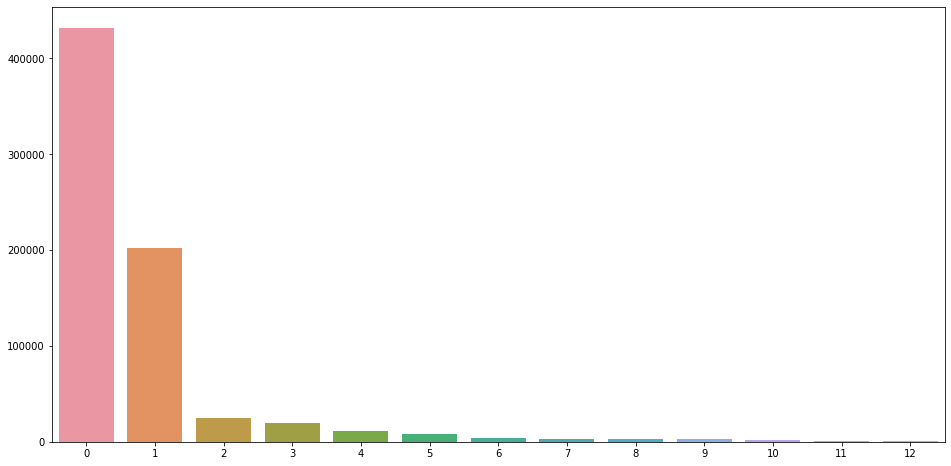

In [432]:
orig_df = pd.read_csv("data/train.csv", low_memory=False)
orig_df = orig_df[orig_df["QA여부"] == "q"]
orig_df = orig_df[["발화문", "인텐트"]]

orig_value_counts = pd.DataFrame(orig_df["인텐트"].value_counts())

plt.figure(figsize=(16, 8))
sns.barplot(x=np.arange(len(orig_value_counts)), y=orig_value_counts["인텐트"].to_numpy())

## Backtranslation

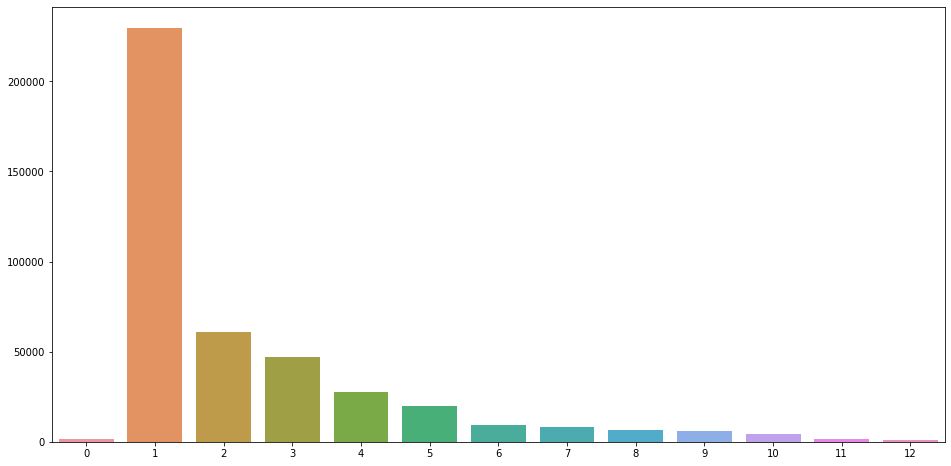

In [594]:
back_translated = joblib.load("outputs/backtranslation/back_translated.v3.joblib")
texts, intents = zip(*back_translated)
back_df = pd.DataFrame({"발화문": texts, "인텐트": intents})
plot_label_distribution(back_df, orig_df["인텐트"].value_counts().index)

## Merge Data

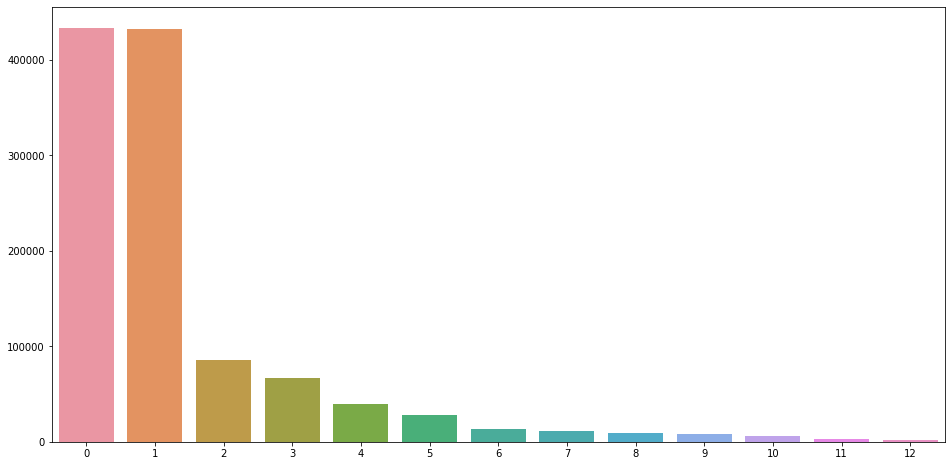

In [544]:
merged_df = pd.concat([orig_df, back_df])
merged_df["발화문"].replace("", np.nan, inplace=True)
merged_df.dropna(inplace=True)
# merged_df.to_csv("data/train+back.v8.csv", index=False)
plot_label_distribution(merged_df, columns=orig_df["인텐트"].value_counts().index)

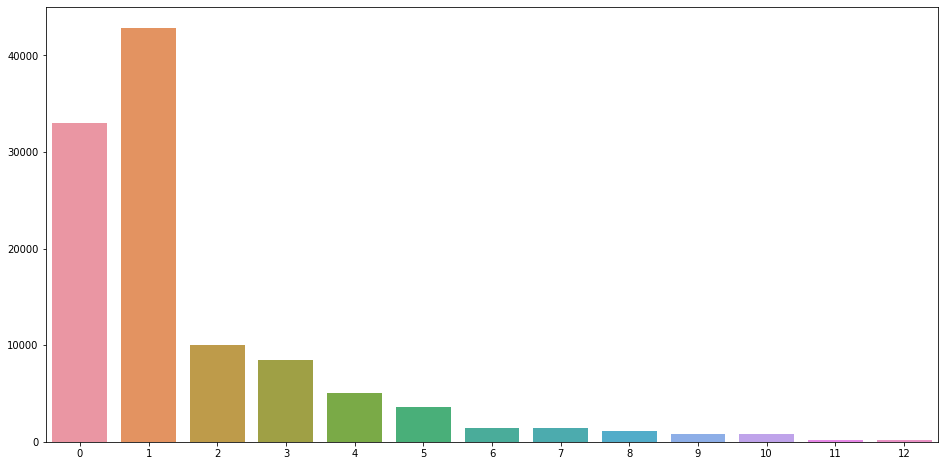

In [308]:
sampling_idx = np.random.choice(len(orig_df), size=len(back_df), replace=False)
sampled_orig_df = orig_df.iloc[sampling_idx]
merged_df2 = pd.concat([sampled_orig_df, back_df])
merged_df2["발화문"].replace("", np.nan, inplace=True)
merged_df2.dropna(inplace=True)
plot_label_distribution(merged_df2, columns=orig_df["인텐트"].value_counts().index)

In [857]:
pd.DataFrame(train_df['인텐트'].value_counts())

,인텐트
제품,417927
배송,156965
교환|반품|환불,23707
행사,19238
결제,11332
AS,8261
구매,4088
웹사이트,3089
포장,2586
부가서비스,2578


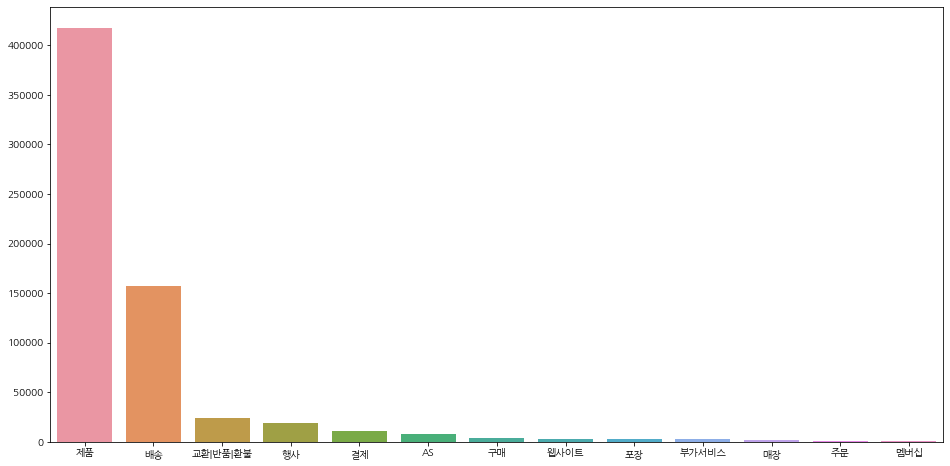

In [20]:
plot_label_distribution(train_df)

## Sampling

In [ ]:
batch_y = np.array([9, 6, 2, 12, 8, 5, 4, 7])
probs = torch.from_numpy((1 - n_samples[batch_y] / n_samples.max()) + 1e-4).clamp(max=1)
probs

tensor([1.0000e-04, 5.3105e-01, 9.4351e-01, 9.5402e-01, 9.9291e-01, 9.9916e-01,
        9.9531e-01, 9.9403e-01], dtype=torch.float64)

## Propensity Score

In [574]:
a = 0.55
b = 1.5
c = (np.log(n_samples.sum()) - 1) * ((b + 1) ** a)
inv_w = 1.0 + c * (n_samples + b) ** (-a)

In [709]:
inv_w

array([1.14197464, 1.12052844, 1.07970185, 1.21245598, 1.30975141,
       1.75773108, 1.02490617, 1.27208256, 1.24789009, 1.016424  ,
       1.53339695, 1.2711742 , 1.08923395])

# NLPAug

In [ ]:
train_dataset = LotteQADataset()

In [371]:
aug = naw.ContextualWordEmbsAug(model_path='klue/bert-base', aug_p=0.1)

In [381]:
%%time
ridx = np.random.randint(len(train_dataset))
original = train_dataset[ridx][0]
augmented = aug.augment(original)

print(f"Original ({ridx}):")
print(original)
print()
print("Augmented:")
print(augmented)

Original (9333):
방에다가 설치까지 해주시고 가시는 건가요?

Augmented:
['방에다가 일부러 너무 가시는 건가요?']
CPU times: user 24.7 s, sys: 221 ms, total: 24.9 s
Wall time: 812 ms


# Data Filtering (LAMBADA)

In [755]:
aug_pred = predict(
    run_id="25ff566b035a4b11b861d03b23dde822", aug_filename="back.v1.csv"
)

  0%|          | 0/26514 [00:00<?, ?it/s]

f1        (micro): 0.5359
prec      (macro): 0.4776
recall    (macro): 0.3276
f1        (macro): 0.3108
prec   (weighted): 0.7561
recall (weighted): 0.5359
f1     (weighted): 0.6060


In [ ]:
pred, back_pred, aug_pred

In [752]:
back_pred["df"].to_excel("outputs/predictions.xlsx", index=False)

In [728]:
train_df = LotteQADataset().df

In [18]:
back_df = pd.read_csv("data/back.v1.csv").drop_duplicates().reset_index(drop=True)

In [19]:
correct = np.where(aug_pred["predictions"] == aug_pred["gt"])[0]
tmp_df1 = pd.DataFrame(train_df["인텐트"].value_counts()).rename(columns={"인텐트": "train"})
tmp_df2 = (
    pd.DataFrame(back_df.iloc[correct]["인텐트"].value_counts())
    .loc[tmp_df1.index]
    .rename(columns={"인텐트": "aug"})
)
tmp_df3 = pd.DataFrame(tmp_df1["train"] + tmp_df2["aug"]).rename(columns={0: "sum"})
tmp_df = pd.concat([tmp_df1, tmp_df2, tmp_df3], axis=1)
tmp_df

,train,aug,sum
제품,417927,1553,419480
배송,156965,170537,327502
교환|반품|환불,23707,19811,43518
행사,19238,12905,32143
결제,11332,5565,16897
AS,8261,8533,16794
구매,4088,3025,7113
웹사이트,3089,259,3348
포장,2586,2499,5085
부가서비스,2578,948,3526


In [54]:
label_idx = le.transform(["부가서비스"])
pd.concat(
    [
        pd.DataFrame({"train": pred["matrix"][label_idx].squeeze()}, index=le.classes_),
        pd.DataFrame(
            {"back": back_pred["matrix"][label_idx].squeeze()}, index=le.classes_
        ),
    ],
    axis=1,
)

,train,back
AS,3,3
결제,1,0
교환|반품|환불,4,5
구매,0,3
매장,2,0
멤버십,0,0
배송,162,86
부가서비스,155,197
웹사이트,0,0
제품,49,85


In [49]:
tmp_df = back_df.iloc[correct]
tmp_df[tmp_df['인텐트'] == 'AS'][:50]

,발화문,인텐트
79,iPhone을 고치기 위해 얼마나 오래 기다려야합니까?,AS
85,기본적으로 서비스에서 벗어나 열차의 수를 묻는 경우 열차의 수를 보는 것이 상식적이...,AS
94,A / S를 받으면 피부가 어떻게됩니까?,AS
108,내가 그것을 구입 한 지 1 년이 지났고 의자 중 하나를 부러 뜨 렸기 때문에 A ...,AS
201,"당신은 trifect를 위한 a/s 서비스를 얻을 수 있습니다, 권리?",AS
220,내가 노트북을 고쳐서 첫날에 다시 가져올 것 같아?,AS
327,Apple 서비스는 연결할 수 없는 경우 새 서비스를 교체합니까?,AS
365,노력 중이야?,AS
422,AS를 받는데 드는 비용을 말해주세요.,AS
449,사용 중인 동안 A/S를 받을 수 있나요?,AS


In [47]:
le.classes_[aug_pred['predictions'][]]

'제품'

In [24]:
train_df[train_df['인텐트'] == '제품']

,발화문,인텐트
0,높이 길이를 좀 더 길게 해주실 수 있나요?,제품
2,거실 총길이가 가로 480세로 230인데 어떤 걸로 신청해야 하나요?,제품
4,화이트 구입 시 봉색이 화이트로 오나요?,제품
7,똑같은 회사에 똑같은 상품인데 2만원 더 비싼데 혹시 상품 이 틀리나요?,제품
8,사이즈를 몇으로 사야 하나요?,제품
...,...,...
652986,차량 풀번호. 핸드폰 번호를 적어야 하는데 이 811 제품으로도 제작이 되나요?,제품
652987,저는 크기는 상관없고 3줄에 같은 싸이즈 가운데 맞춤으로 제작되길 원하거든요 811...,제품
652989,일반 간이영수증에 찍으려고 하는데 사이즈 뭐로 해야 하나요?,제품
652991,입력 내용 다시 입력해야 되나요?,제품


In [35]:
test_df[test_df['인텐트'] == 'AS'].iloc[:50]

,발화문,인텐트
119,커튼 길이가 좀 길어요수선 가능한가요?,AS
332,245CM 로 길이를 연장하면 추가 금액은 얼마인가요?,AS
781,구매 후 이사를 갈 경우 별도로 AS 신청을 하여 설치해야 하나요?,AS
800,제품 AS는 어떻게 되나요?,AS
808,무상A/S는 몇 년인가요?,AS
947,현대홈쇼핑은 A/S 기간이 10년이던 데 다른 점이 무엇인지?,AS
1101,AS는 어떻게 받아야 하나요?,AS
1172,혹시 쇼파수리도 하는지요?,AS
1398,AS 가능한가요?,AS
1538,자코모쇼파에비뉴엘모카주문했는 대 무상 AS 기간은 언제까지 인가요?,AS


In [38]:
le.classes_[back_pred['predictions'][6042]]

'제품'

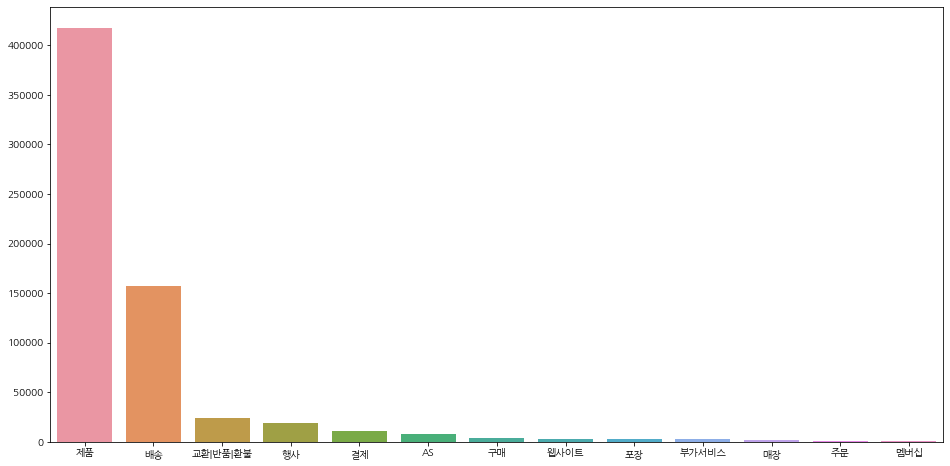

In [56]:
plot_label_distribution(train_df)

In [58]:
tmp_df = train_df[train_df["인텐트"] == "제품"]
removed = np.random.choice(len(tmp_df), size=len(tmp_df) // 2, replace=False)
removed

array([417655, 386695, 274028, ...,  14622, 303902, 398243])

In [61]:
removed_train_df = train_df.drop(tmp_df.iloc[removed].index)

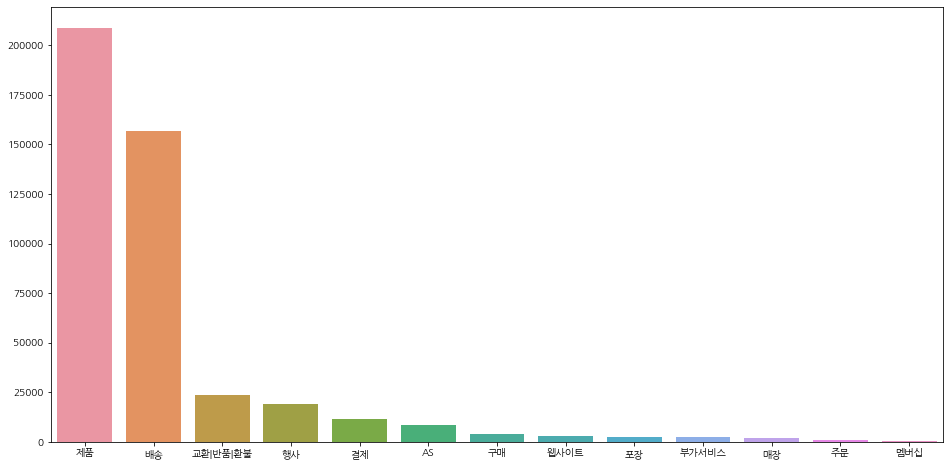

In [62]:
plot_label_distribution(removed_train_df)

In [73]:
len(back_df)

424220

In [76]:
tmp_df = back_df.iloc[correct]

In [77]:
train_back_df = pd.concat([removed_train_df, tmp_df[~tmp_df['인텐트'].isin(['제품', '배송'])]])

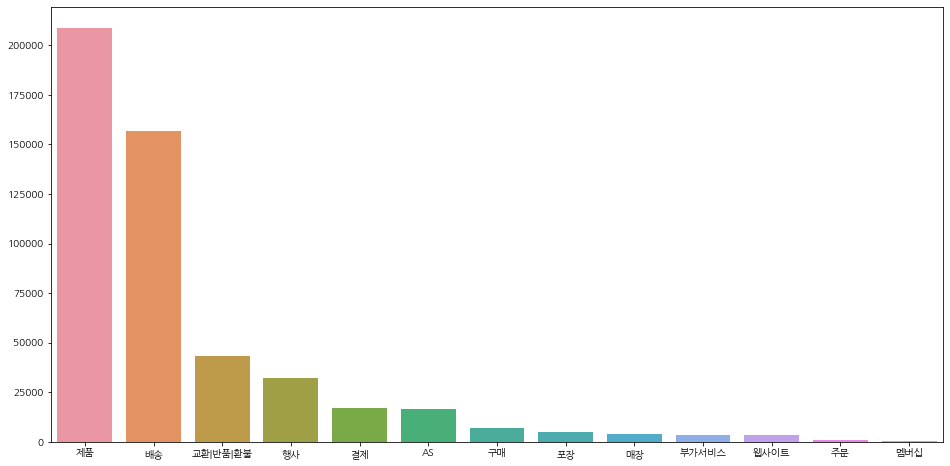

In [78]:
plot_label_distribution(train_back_df)

In [80]:
train_back_df.to_csv("data/train+back.v10.csv", index=False)

# GPT2

In [669]:
pretrained_model_name = "skt/kogpt2-base-v2"
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
model = AutoModelForCausalLM.from_pretrained(pretrained_model_name)

In [707]:
text = "주문"
inputs = tokenizer(text, return_tensors='pt')
inputs

{'input_ids': tensor([[16812]]), 'attention_mask': tensor([[1]])}

In [ ]:
model.to(device)

In [726]:
%%time
gen_ids = model.generate(
    **inputs,
    max_length=128,
    repetition_penalty=2.0,
)
generated = tokenizer.batch_decode(gen_ids)
print(generated[0])

주문했다.
이날 오전 9시30분께 서울 종로구 세종로 정부중앙청사 별관 2층 회의실에서 열린 이 전 대통령과의 독대에서는 김백준 총무기획관이 "대통령께서 (김대중)전 대통령의 서거에 대해 애도를 표하고 유족들에게 위로의 말씀을 드린다"고 말했다.
이어 "이번 사태는 김대중 대통령이 지난해 12월19일 대국민담화에서 밝힌 대로 국민통합과 국가발전을 위해 혼신의 노력을 다하는 과정에서 발생한 것"이라며 이같이 밝혔다.
그는 또 박근혜 한나라당 대표의 '독도 방문과 관련,'박 대표가 직접 나서야 한다는 주장에 대해서는 일축
CPU times: user 2min 17s, sys: 77.2 ms, total: 2min 17s
Wall time: 3.87 s


In [723]:
sorted(tokenizer.get_vocab().items(), key=lambda key: key[1])

[('<s>', 0),
 ('</s>', 1),
 ('<usr>', 2),
 ('<pad>', 3),
 ('<sys>', 4),
 ('<unk>', 5),
 ('<mask>', 6),
 ('<d>', 7),
 ('</d>', 8),
 ('<unused0>', 9),
 ('<unused1>', 10),
 ('<unused2>', 11),
 ('<unused3>', 12),
 ('<unused4>', 13),
 ('<unused5>', 14),
 ('<unused6>', 15),
 ('<unused7>', 16),
 ('<unused8>', 17),
 ('<unused9>', 18),
 ('<unused10>', 19),
 ('<unused11>', 20),
 ('<unused12>', 21),
 ('<unused13>', 22),
 ('<unused14>', 23),
 ('<unused15>', 24),
 ('<unused16>', 25),
 ('<unused17>', 26),
 ('<unused18>', 27),
 ('<unused19>', 28),
 ('<unused20>', 29),
 ('<unused21>', 30),
 ('<unused22>', 31),
 ('<unused23>', 32),
 ('<unused24>', 33),
 ('<unused25>', 34),
 ('<unused26>', 35),
 ('<unused27>', 36),
 ('<unused28>', 37),
 ('<unused29>', 38),
 ('<unused30>', 39),
 ('<unused31>', 40),
 ('<unused32>', 41),
 ('<unused33>', 42),
 ('<unused34>', 43),
 ('<unused35>', 44),
 ('<unused36>', 45),
 ('<unused37>', 46),
 ('<unused38>', 47),
 ('<unused39>', 48),
 ('<unused40>', 49),
 ('<unused41>', 50),